In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [14]:
import warnings
warnings.filterwarnings('ignore')
import glob
import matplotlib.pyplot as plt
import seaborn as sns
# Modified path to load the available aave.csv file
path = "/content/aave.csv"
files = glob.glob(path)

dfs = []

for file in files:
    name = file.split("/")[-1].replace(".csv", "")
    # Skip the first row, as it appears to contain incorrect header information or garbage data.
    temp = pd.read_csv(file, skiprows=1)
    temp.columns = ["Date","Close","High","Low","Open","Volume"]

    # Convert 'Close', 'High', 'Low', 'Open', 'Volume' to numeric, coercing errors
    for col in ["Close", "High", "Low", "Open", "Volume"]:
        temp[col] = pd.to_numeric(temp[col], errors='coerce')

    temp["asset"] = name
    temp["Date"] = pd.to_datetime(temp["Date"])
    dfs.append(temp)

df = pd.concat(dfs, ignore_index=True)
df.head()

,Date,Close,High,Low,Open,Volume,asset
0,2020-10-02,0.516571,0.516571,0.000000,0.000000,0,aave
1,2020-10-03,53.151489,65.305939,0.523801,0.523836,0,aave
2,2020-10-04,52.675034,55.070354,50.688992,53.179859,0,aave
3,2020-10-05,53.219242,55.112358,49.787899,52.675034,0,aave
4,2020-10-06,42.401600,53.402271,40.734577,53.291969,583091,aave


In [5]:
df.shape

(1923, 7)

In [7]:
cols = ["Open","High","Low","Close","Volume"]

df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
df = df.sort_values(["asset","Date"])

In [8]:
coverage = df.groupby("asset")["Date"].agg(["min","max","count"]).sort_values("count", ascending=False)
coverage.head()

,min,max,count
asset,,,
aave,2020-10-02,2026-01-05,1922


In [9]:
df = df.sort_values(["asset","Date"])

df["return"] = df.groupby("asset")["Close"].pct_change()
df["log_return"] = np.log(df["Close"] / df.groupby("asset")["Close"].shift(1))
df["range_pct"] = (df["High"] - df["Low"]) / df["Close"]
df["volume_usd"] = df["Close"] * df["Volume"]
df.tail()

,Date,Close,High,Low,Open,Volume,asset,return,log_return,range_pct,volume_usd
1917,2026-01-01,148.690201,149.250046,144.977951,146.109222,124361906,aave,0.017326,0.017178,0.028732,1.849140e+10
1918,2026-01-02,165.010849,165.639511,147.802856,148.691238,288400916,aave,0.109763,0.104146,0.108094,4.758928e+10
1919,2026-01-03,163.000946,167.054443,157.981537,165.010010,218112844,aave,-0.012180,-0.012255,0.055662,3.555260e+10
1920,2026-01-04,163.916565,165.965317,160.902832,163.001221,181854450,aave,0.005617,0.005602,0.030885,2.980896e+10
1921,2026-01-05,171.789383,171.789383,162.408142,163.950745,237375952,aave,0.048029,0.046912,0.054609,4.077867e+10


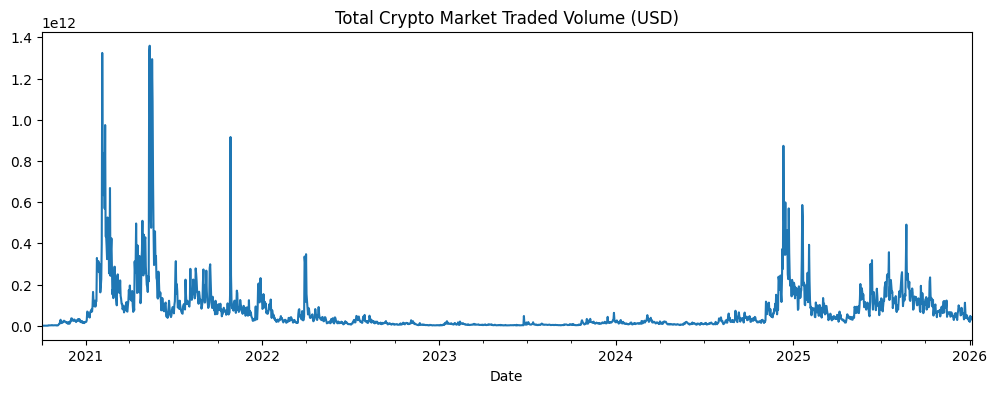

In [10]:
daily_volume = df.groupby("Date")["volume_usd"].sum()

plt.figure(figsize=(12,4))
daily_volume.plot()
plt.title("Total Crypto Market Traded Volume (USD)")
plt.show()

In [12]:
df["return"].quantile([0.01, 0.05, 0.95, 0.99])

,return
0.01,-0.148011
0.05,-0.083893
0.95,0.095360
0.99,0.187491


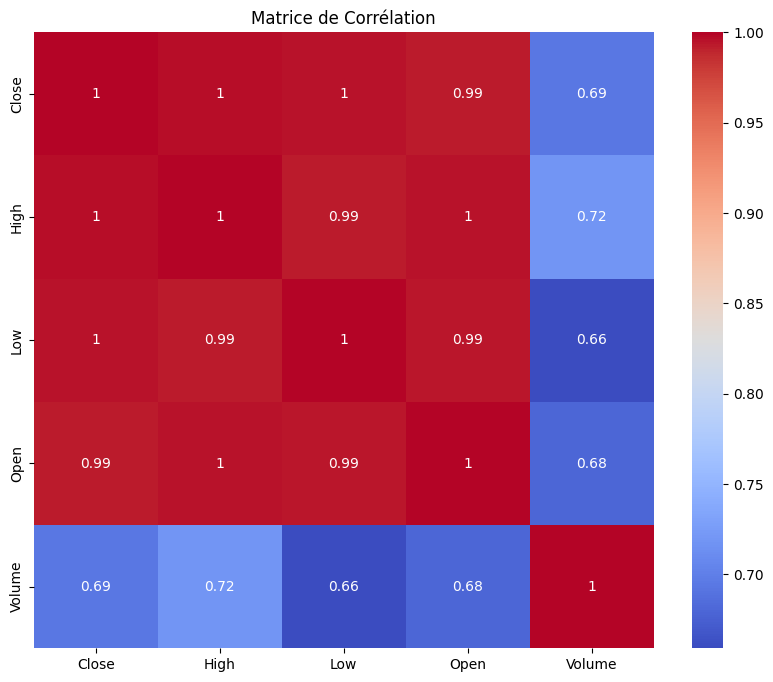

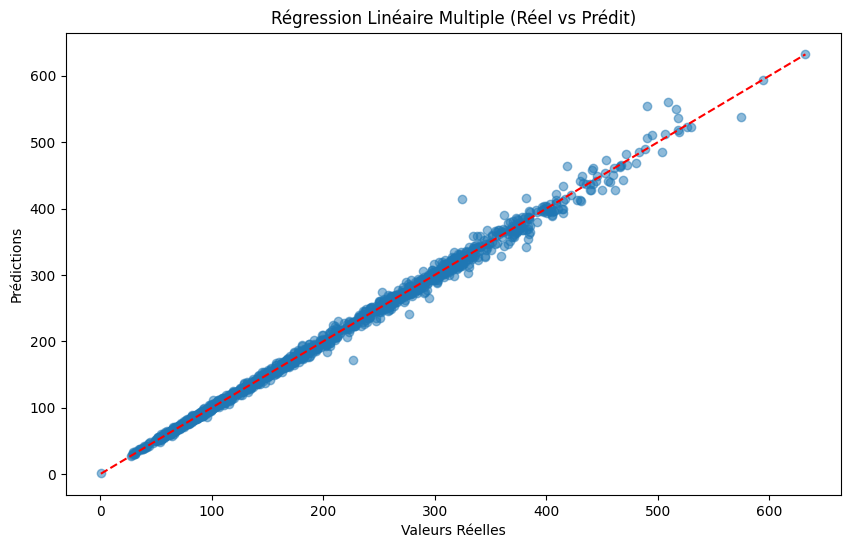

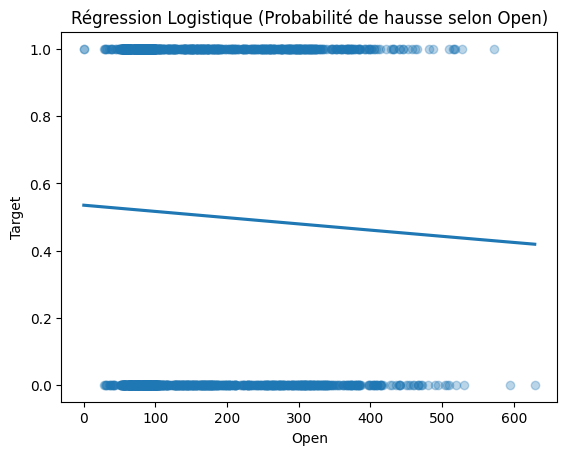

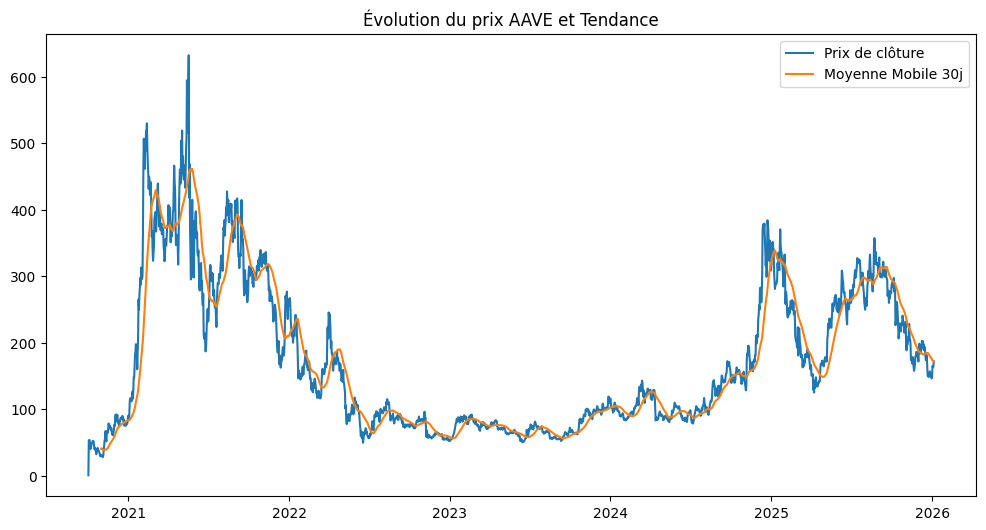

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import numpy as np

# Chargement et nettoyage
df = pd.read_csv('aave.csv', skiprows=[1])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
cols = ['Close', 'High', 'Low', 'Open', 'Volume']
df[cols] = df[cols].apply(pd.to_numeric)

# 1. Matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

# 2. Régression Linéaire Multiple (Prédire Close via Open, High, Low)
X = df[['Open', 'High', 'Low']]
y = df['Close']
model_lin = LinearRegression().fit(X, y)
plt.figure(figsize=(10, 6))
plt.scatter(y, model_lin.predict(X), alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Régression Linéaire Multiple (Réel vs Prédit)')
plt.show()

# 3. Régression Logistique (Cible : Close > Open)
df['Target'] = (df['Close'] > df['Open']).astype(int)
X_log = df[['Open', 'Volume']]
model_log = LogisticRegression().fit(X_log, df['Target'])
sns.regplot(x='Open', y='Target', data=df, logistic=True, ci=None, scatter_kws={'alpha':0.3})
plt.title('Régression Logistique (Probabilité de hausse selon Open)')
plt.show()

# 4. Courbes pertinentes (Prix de clôture et Moyenne Mobile)
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Prix de clôture')
plt.plot(df['Date'], df['Close'].rolling(window=30).mean(), label='Moyenne Mobile 30j')
plt.legend()
plt.title('Évolution du prix AAVE et Tendance')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')